In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import tdastro

sys.path.append(
    str((Path(tdastro.__file__).parent / ".." / ".." / "tests" / "tdastro" / "sources").resolve())
)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sncosmo

In [4]:
from test_snia import test_snia_end2end

In [5]:
res = test_snia_end2end(
    '/Users/hombit/projects/lincc-frameworks/tdastro/tests/tdastro/data/opsim_small.db', opsim_db_file=None, opsim=True, nsample=100, return_result=True,
    # phase_rest=np.linspace(-15, 45, 20),
    phase_rest=None,
    passbands_dir='/Users/hombit/projects/lincc-frameworks/tdastro/tests/tdastro/data/passbands',
)

No overlap time in opsim for (ra,dec)=(13.97,-16.46)
No overlap time in opsim for (ra,dec)=(4.94,-22.46)
No overlap time in opsim for (ra,dec)=(19.36,-7.72)
No overlap time in opsim for (ra,dec)=(22.53,-22.70)
No overlap time in opsim for (ra,dec)=(10.15,-28.54)
No overlap time in opsim for (ra,dec)=(4.44,-16.64)
No overlap time in opsim for (ra,dec)=(22.77,-16.70)
No overlap time in opsim for (ra,dec)=(16.49,-28.33)
No overlap time in opsim for (ra,dec)=(25.60,-13.52)
No overlap time in opsim for (ra,dec)=(25.76,-25.61)
No overlap time in opsim for (ra,dec)=(22.55,-19.69)


In [20]:
hostmass = [x["parameter_values"]["hostmass"] for x in res]
x1 = [x["parameter_values"]["x1"] for x in res]
x0 = [x["parameter_values"]["x0"] for x in res]
c = [x["parameter_values"]["c"] for x in res]
z = [x["parameter_values"]["redshift"] for x in res]
t0 = [x["parameter_values"]["t0"] for x in res]
distmod = [x["parameter_values"]["distmod"] for x in res]

(array([16.,  7., 11., 12.,  6.,  9.,  4., 11.,  6.,  7.]),
 array([ 7.15518603,  7.63812131,  8.12105658,  8.60399185,  9.08692712,
         9.5698624 , 10.05279767, 10.53573294, 11.01866821, 11.50160349,
        11.98453876]),
 <BarContainer object of 10 artists>)

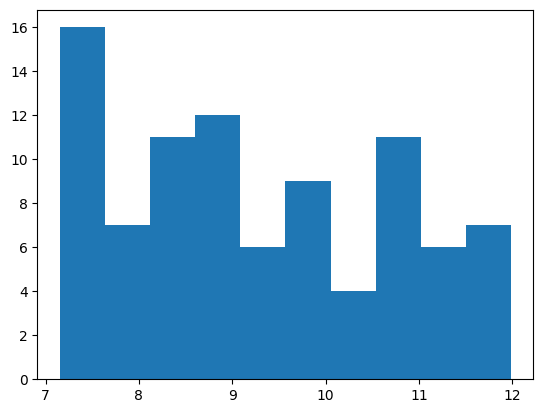

In [16]:
plt.hist(hostmass)

0.8667836289546758


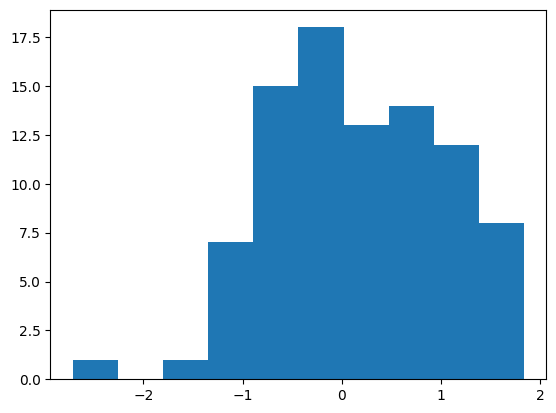

In [17]:
plt.hist(x1)
print(np.std(x1))

(array([ 3.,  6., 10., 13.,  9., 17., 19.,  8.,  2.,  2.]),
 array([-0.04299508, -0.03385037, -0.02470566, -0.01556095, -0.00641624,
         0.00272847,  0.01187318,  0.02101789,  0.0301626 ,  0.03930731,
         0.04845202]),
 <BarContainer object of 10 artists>)

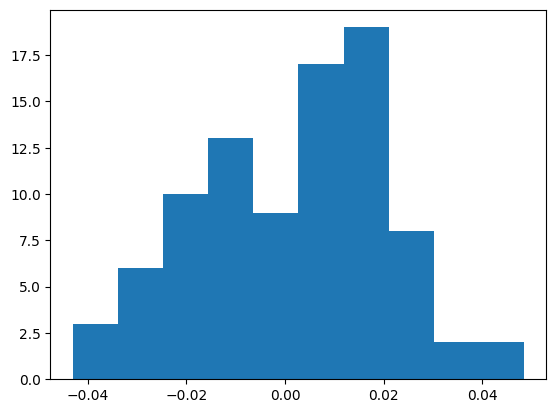

In [9]:
plt.hist(c)

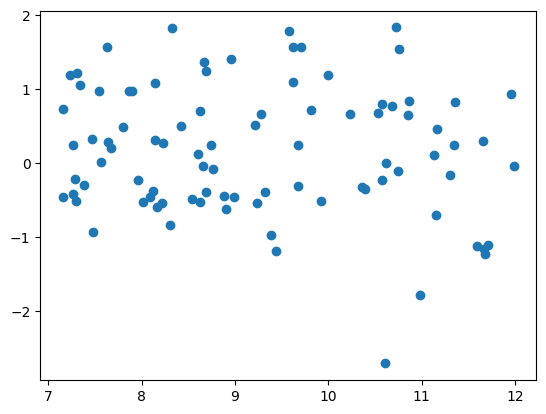

In [10]:
plt.scatter(hostmass, x1)

(array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],


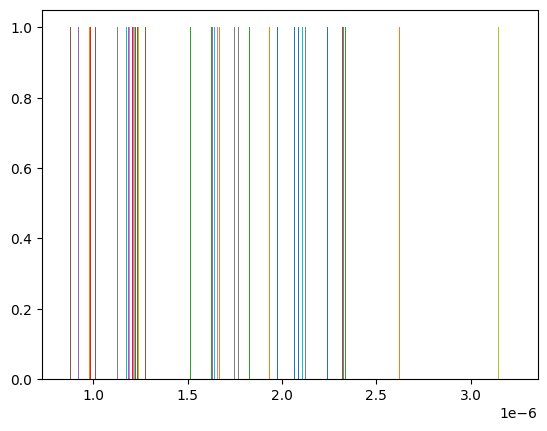

In [11]:
plt.hist(x0)

(array([ 5.,  9., 16., 12., 11.,  7.,  8.,  9.,  6.,  6.]),
 array([0.01004894, 0.01099313, 0.01193732, 0.01288152, 0.01382571,
        0.01476991, 0.0157141 , 0.0166583 , 0.01760249, 0.01854669,
        0.01949088]),
 <BarContainer object of 10 artists>)

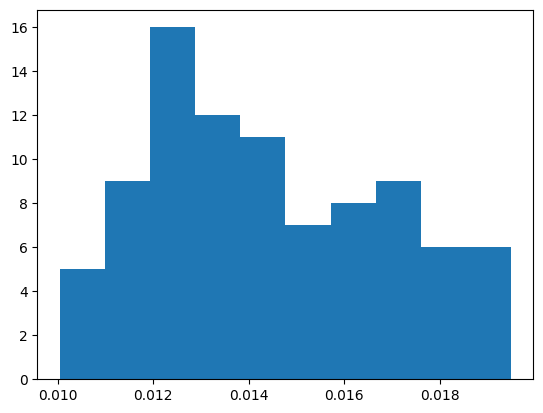

In [12]:
plt.hist(z)

0.5529420789745707


ValueError: x and y must be the same size

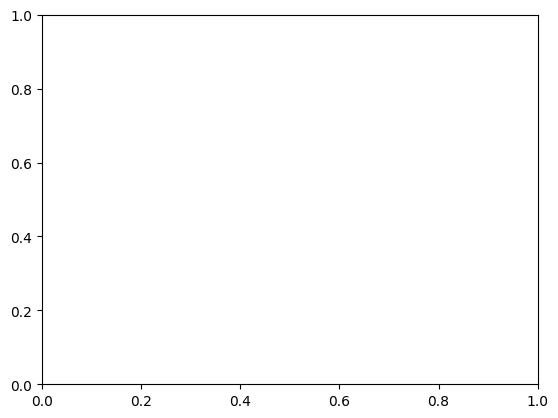

In [13]:
# cosmo = FlatLambdaCDM(H0=73, Om0=0.3)
# distmod = cosmo.distmod(z).value

#    x0 = np.power(10., -0.4 * (distmod - alpha * x1 + beta * c + m_abs))
#  -2.5*log10(x0) = distmod -alpha*x1 + beta*c + m_abs

mb = -2.5 * np.log10(x0)
print(np.std(mb - distmod))

plt.scatter(z, mb - distmod)
plt.show()

alpha = 0.14
beta = 3.1
mu = np.array(mb) + alpha * np.array(x1) - beta * np.array(c) + 19.3
print(np.std(mu - distmod))

plt.scatter(z, mu - distmod)

plt.show()

In [ ]:
plt.scatter(z, mb)
plt.show()
plt.scatter(z, mu)
plt.show()

In [ ]:
plt.scatter(hostmass, mu - distmod)
plt.show()

In [ ]:
for i in range(0, 3):
    try:
        plt.plot(res[i]["wavelengths_rest"] * (1 + z[i]), res[i]["flux_flam"][0], color="r")
    except Exception:
        continue
    saltpars = {"x0": x0[i], "x1": x1[i], "c": c[i], "z": z[i], "t0": t0[i]}
    model = sncosmo.Model("salt2-h17")
    model.update(saltpars)
    print(saltpars)
    print(model.parameters)
    print(res[i]["times"] - t0[i])
    wave = res[i]["wavelengths_rest"] * (1 + z[i])
    plt.plot(wave, model.flux(res[i]["times"][0], wave), color="g")
    plt.show()

In [ ]:
for i in range(0, 3):
    phase_obs = res[i]["phase_rest"] * (1 + z[i])
    times = res[i]["times"]
    colors = "gr"
    for color, f in zip("gr", colors):
        plt.plot(
            times, res[i]["bandfluxes"]["LSST_" + f], "-", marker="o", label=f, color=color, alpha=0.6, lw=2
        )
        saltpars = {"x0": x0[i], "x1": x1[i], "c": c[i], "z": z[i], "t0": t0[i]}
        model = sncosmo.Model("salt2-h17")
        model.update(saltpars)
        print(saltpars)
        flux = model.bandflux("lsst" + f, times, zpsys="ab", zp=8.9 + 2.5 * 9)  # -48.6)
        plt.plot(times, flux, "--", label=f, color=color)
        plt.legend()
    plt.show()